# Use external API

In [1]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

In [2]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import matplotlib.font_manager
import matplotlib.pyplot as plt
import joypy
import palantir
%matplotlib inline

In [3]:
import warnings
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', RuntimeWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', pd.errors.PerformanceWarning)

In [4]:
adata =sc.read_h5ad('8_color_data_set.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 859431 × 15
    obs: 'sample_id'
    uns: 'gate_hierarchy', 'transforms'
    obsm: 'gate_index'
    varm: 'stats'

In [6]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=75, facecolor='white')
sc.logging.print_header()

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==1.3.5 scikit-learn==1.2.2 statsmodels==0.13.5 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.8


## Preprocessing

In [7]:
adata.var_names

Index(['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'TNFa FITC FLR-A',
       'CD8 PerCP-Cy55 FLR-A', 'IL2 BV421 FLR-A', 'Aqua Amine FLR-A',
       'IFNg APC FLR-A', 'CD3 APC-H7 FLR-A', 'CD107a PE FLR-A',
       'CD4 PE-Cy7 FLR-A', 'Time'],
      dtype='object')

In [8]:
exclude = ['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'Time']

Only keep fluroescence intensity markers

In [9]:
adata = adata[:, ~adata.var_names.isin(exclude)]

In [10]:
markers = [
    'Aqua Amine FLR-A',
    'CD3 APC-H7 FLR-A', 
    'CD4 PE-Cy7 FLR-A',
    'CD8 PerCP-Cy55 FLR-A',
    'TNFa FITC FLR-A',
    'IL2 BV421 FLR-A', 
    'IFNg APC FLR-A', 
    'CD107a PE FLR-A',
]

## Prepare data

In [11]:
data = sc.pp.subsample(adata, n_obs=50_000, copy=True)

In [12]:
sc.tl.pca(data)

computing PCA
    with n_comps=7
    finished (0:00:00)


In [13]:
sc.pp.neighbors(data, knn=30)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:12)


In [14]:
sc.tl.diffmap(data)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9992617  0.99866223 0.99734545 0.99591607 0.9938974
     0.9920424  0.9911721  0.9898618  0.98975694 0.9887384  0.986979
     0.98556006 0.9841498  0.982506  ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:14)


## Phneograph

In [15]:
sce.tl.phenograph(data, clustering_algo="louvain", k=30)

PhenoGraph clustering
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.4723358154296875 seconds
Jaccard graph constructed in 3.386030912399292 seconds
Wrote graph to binary file in 0.6305170059204102 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.87884
After 18 runs, maximum modularity is Q = 0.881656
Louvain completed 38 runs in 45.324130058288574 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 51.9949049949646 seconds
    finished (0:00:51)


In [16]:
sc.tl.tsne(data)

computing tSNE
    using data matrix X directly
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:01:49)


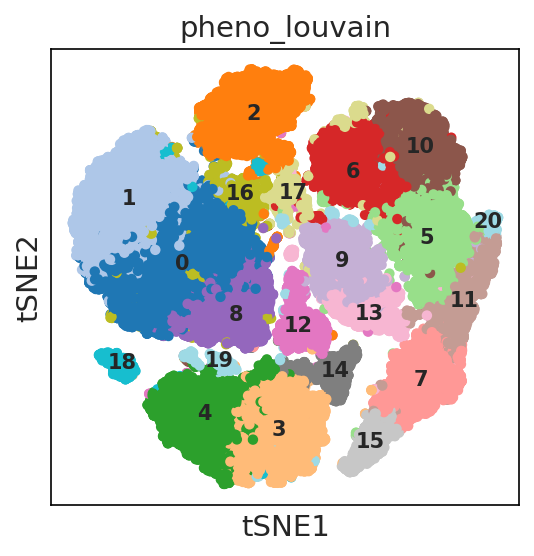

In [17]:
sc.pl.tsne(
    data, color = ['pheno_louvain'], s = 100,
    legend_fontsize = 10,
    legend_loc='on data',
    palette='tab20'
)

In [18]:
sc.tl.dendrogram(data, groupby='pheno_louvain')

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_pheno_louvain']`


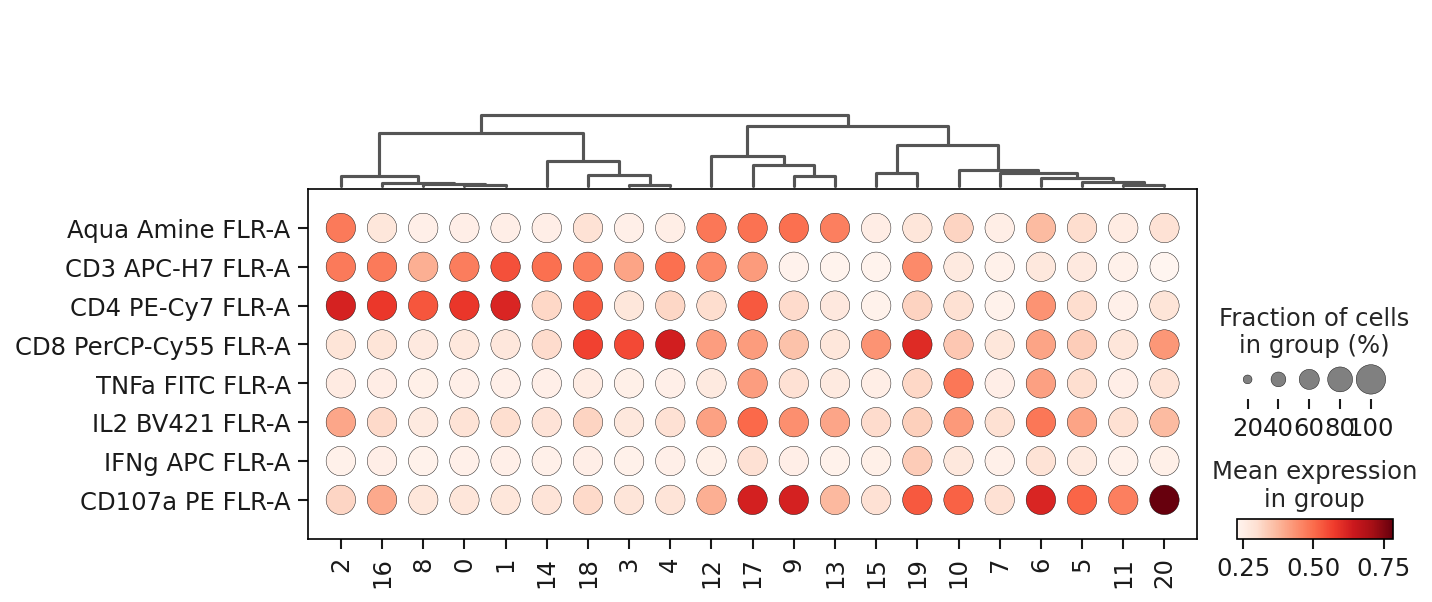

In [19]:
sc.pl.dotplot(data, markers, groupby='pheno_louvain', swap_axes=True, dendrogram=True)

## Wishbone

In [21]:
sce.tl.wishbone(
    adata=data, 
    start_cell='263311',
    components=[2, 1], 
    num_waypoints=150,
)

Building lNN graph...
lNN computed in : 0.17 seconds
Determining waypoints if not specified...
Determining shortest path distances and perspectives....
......................................................................................................................................................
Time for determining distances and perspectives: 265.12 seconds
Determining branch point and branch associations...
Running iterations...
Iteration: 2
Correlation with previous iteration:  0.9954
1 realignment iterations


In [32]:
%matplotlib inline

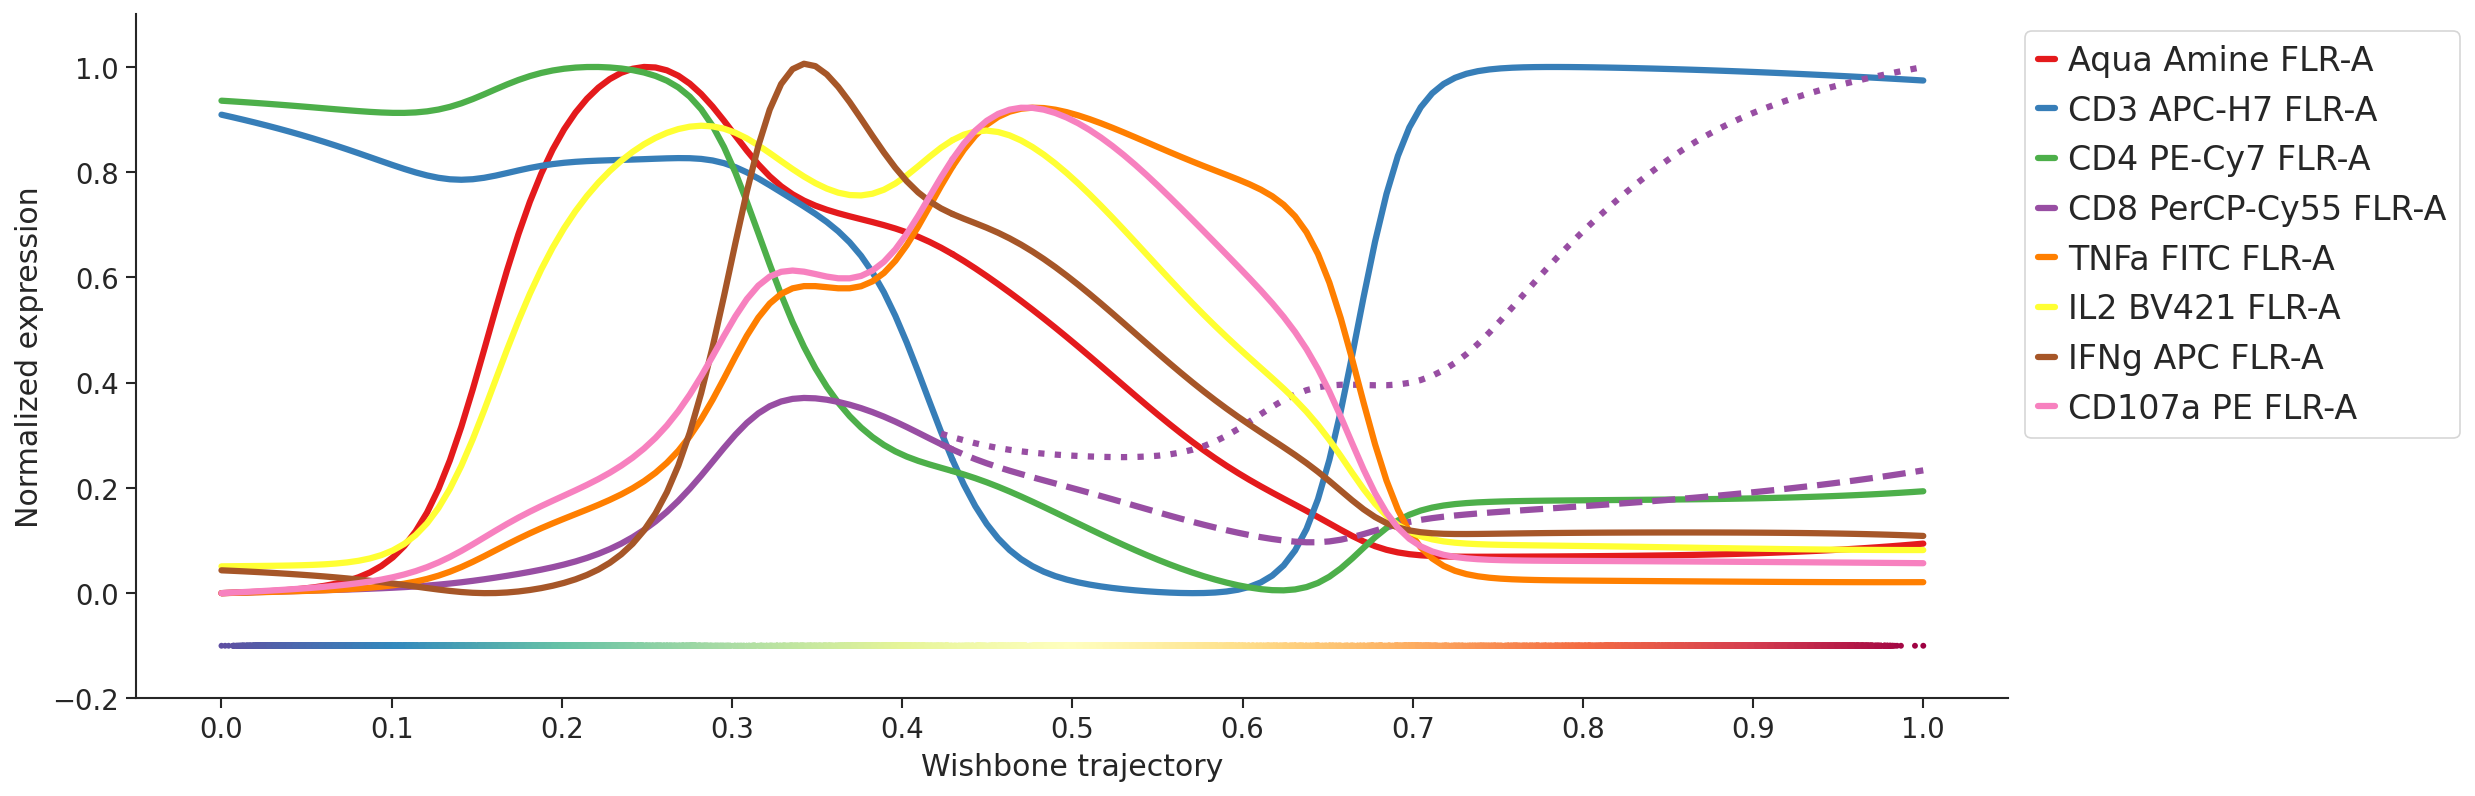

In [37]:
sce.pl.wishbone_marker_trajectory(data, markers, show=True)

## Phate

In [23]:
sce.tl.phate(data, k=5, a=20, t=150)

computing PHATE
Calculating PHATE...
  Running PHATE on 50000 observations and 8 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 8.47 seconds.
    Calculating affinities...
    Calculated affinities in 0.24 seconds.
  Calculated graph and diffusion operator in 8.74 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 4.53 seconds.
    Calculating KMeans...
    Calculated KMeans in 5.47 seconds.
  Calculated landmark operator in 11.67 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.28 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.94 seconds.
Calculated PHATE in 24.63 seconds.
    finished: added
    'X_phate', PHATE coordinates (adata.obsm) (0:00:24)


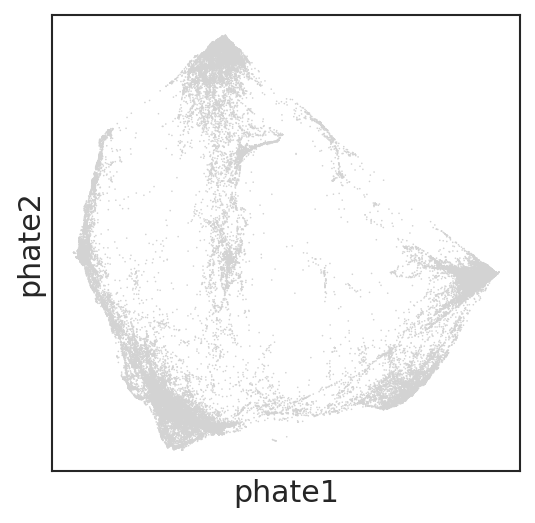

In [34]:
sce.pl.phate(data)

## Palantir

In [25]:
sce.tl.palantir(data, n_components=5, knn=30)

Palantir Diffusion Maps in progress ...
Determing nearest neighbor graph...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)


In [26]:
sc.tl.tsne(data, n_pcs=2, use_rep='X_palantir_multiscale', perplexity=150)

computing tSNE
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:02:28)


In [27]:
start_cell = '263311'
pr_res = sce.tl.palantir_results(
    data,
    early_cell=start_cell,
    ms_data='X_palantir_multiscale',
    num_waypoints=500,
)

Palantir computing waypoints..
Sampling and flocking waypoints...
Time for determining waypoints: 0.029988181591033936 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...


findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling bac

Time for shortest paths: 0.6489532669385274 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9999
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [28]:
sc.tl.umap(data)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:40)


In [29]:
umap = pd.DataFrame(data.obsm['X_umap'], index=data.obs_names)

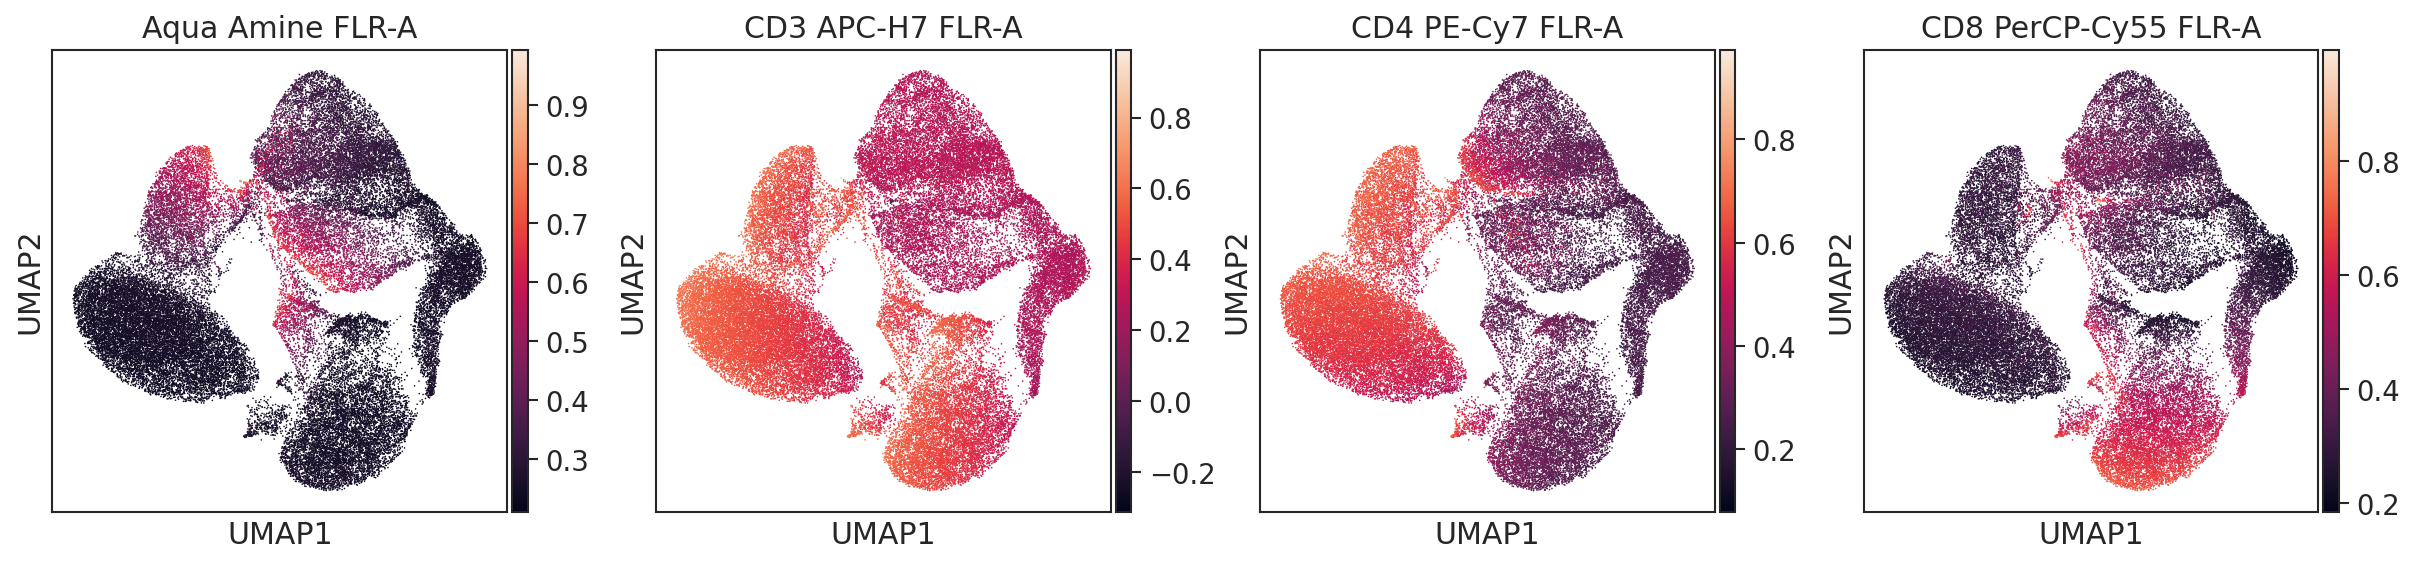

In [35]:
sc.pl.embedding(data, basis='umap', color=markers[:4])

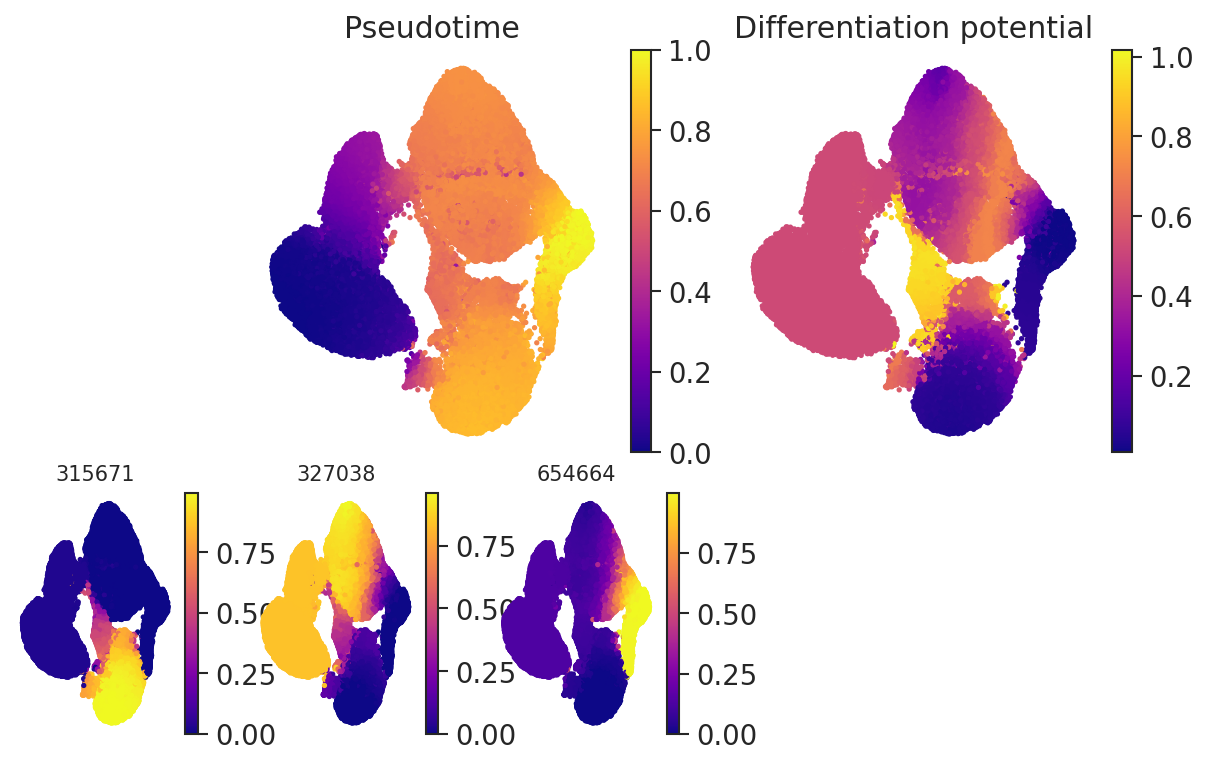

In [36]:
palantir.plot.plot_palantir_results(pr_res, umap)